# Problem Set #5

## MACS 30150, Dr. Evans

## Yiqing Zheng

## Problem 1

part (a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = np.loadtxt('data\incomes.txt')

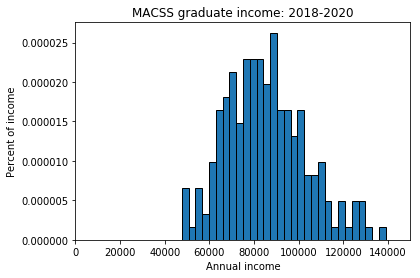

In [3]:
num_bins = 30
plt.hist(data, num_bins, density=True, edgecolor='k')
plt.title('MACSS graduate income: 2018-2020')
plt.xlabel(r'Annual income')
plt.ylabel('Percent of income')
plt.xlim([0, 150000]);

part (b)

In [4]:
from math import sqrt
import scipy.integrate as intgr
import scipy.optimize as opt
import scipy.stats as sts
import numpy.linalg as lin

In [5]:
def log_norm_pdf(x, mu, sigma):
    return (x * sigma * (2 * np.pi)**0.5)**(-1) * np.exp(-(np.log(x) - mu)**2/(2 * sigma**2))

def trunc_log_norm(x, mu, sigma, cut_lb, cut_ub):
    
    if cut_ub == "None" and cut_lb == "None":
        prob_notcut = 1.0
    
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    
    pdf_vals = log_norm_pdf(x, mu, sigma)/prob_notcut
    return pdf_vals

In [6]:
def data_moments(x):
    return (x.mean(), data.std())

def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_log_norm(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_log_norm(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [51]:
mu_init = 11
sigma_init = 0.5
params_init = np.array([mu_init, sigma_init])
W_hat = np.eye(2)
gmm_args = (data, 0.0, 150000.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((None, None), (1e-10, None)))

In [52]:
mu_GMM1, sigma_GMM1 = results.x
func_value1 = results.fun
mean_model1, std_model1 = model_moments(mu_GMM1, sigma_GMM1, 0.0, 150000.0)
mean_data1, std_data1 = data_moments(data)
err1 = err_vec(data, mu_GMM1, sigma_GMM1, 0.0, 150000, simple=True)
print(f'The value of the GMM criterion function: {func_value1}\n')
print(f'GMM estimated mu: {mu_GMM1}, GMM estimated simga: {sigma_GMM1}.\n')
print(f'Mean of data: {mean_data1}, SD of data: {std_data1}.')
print(f'Mean of model: {mean_model1}, SD of model: {std_model1}.\n')
print(f'The difference between data and model moments is \n {err1}.')

The value of the GMM criterion function: [[6.39927099e-16]]

GMM estimated mu: 11.33359961340108, GMM estimated simga: 0.21325529509280874.

Mean of data: 85276.82360625811, SD of data: 17992.542128046523.
Mean of model: 85276.82405854983, SD of model: 17992.541683009535.

The difference between data and model moments is 
 [[ 0.00045229]
 [-0.00044504]].


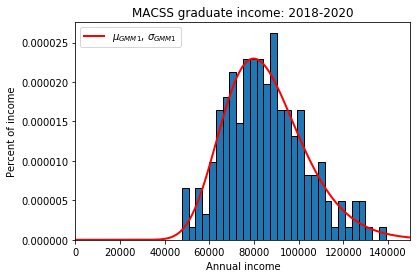

In [9]:
plt.hist(data, num_bins, density=True, edgecolor='k')
plt.title('MACSS graduate income: 2018-2020')
plt.xlabel(r'Annual income')
plt.ylabel('Percent of income')

sample = np.linspace(0, 150000, 200000)
plt.plot(sample, trunc_log_norm(sample, mu_GMM1, sigma_GMM1, 0.0, 150000.0),linewidth=2,
         color='r', label='$\mu_{GMM1}$, $\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.xlim([0, 150000]);

part (c)

In [10]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model        
        Err_mat[1, :] = (np.sqrt(pts - mean_data1)**2) - std_model  
        # Note that we need the standard deviation of the data instead of variance, so we need add np.sqrt here.
    else:
        Err_mat[0, :] = (pts - mean_model)/mean_model
        Err_mat[1, :] = (np.sqrt((pts - mean_data1)**2) - std_model)/std_model
    return Err_mat

In [11]:
Err_mat = get_Err_mat2(data, mu_GMM1, sigma_GMM1, 0, 150000, simple=False)
VCV2 = (1 / data.shape[0]) * (Err_mat @ Err_mat.T)
print(VCV2)
W_hat2 = lin.inv(VCV2)
print(W_hat2)

[[0.04451671 0.02724079]
 [0.02724079 0.40593057]]
[[23.42542598 -1.57201036]
 [-1.57201036  2.56896839]]


In [50]:
params_init2 = np.array([mu_GMM1, sigma_GMM1])
gmm_args2 = (data, 0.0, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init2, args=(gmm_args2),
                        method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results2

      fun: array([[2.6431071e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.19717314e-07, -1.25892754e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

In [40]:
mu_GMM2, sigma_GMM2 = results2.x
func_value2 = results2.fun
mean_model2, std_model2 = model_moments(mu_GMM2, sigma_GMM2, 0.0, 150000.0)
err2 = err_vec(data, mu_GMM2, sigma_GMM2, 0.0, 150000, simple=True)
print(f'The value of the GMM criterion function: {func_value2}\n')
print(f'GMM estimated mu: {mu_GMM2}, GMM estimated simga: {sigma_GMM2}.\n')
print(f'Mean of data: {mean_data1}, SD of data: {std_data1}.')
print(f'Mean of model: {mean_model2}, SD of model: {std_model2}.\n')
print(f'The difference between data and model moments is \n {err2}.')

The value of the GMM criterion function: [[2.6431071e-15]]

GMM estimated mu: 11.33359961340108, GMM estimated simga: 0.21325529509280874.

Mean of data: 85276.82360625811, SD of data: 17992.542128046523.
Mean of model: 85276.82405854983, SD of model: 17992.541683009535.

The difference between data and model moments is 
 [[ 0.00045229]
 [-0.00044504]].


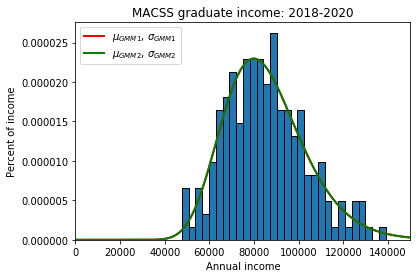

In [14]:
plt.hist(data, num_bins, density=True, edgecolor='k')
plt.title('MACSS graduate income: 2018-2020')
plt.xlabel(r'Annual income')
plt.ylabel('Percent of income')

sample = np.linspace(0, 150000, 200000)
plt.plot(sample, trunc_log_norm(sample, mu_GMM1, sigma_GMM1, 0.0, 150000.0),linewidth=2,
         color='r', label='$\mu_{GMM1}$, $\sigma_{GMM1}$')
plt.plot(sample, trunc_log_norm(sample, mu_GMM2, sigma_GMM2, 0.0, 150000.0),linewidth=2,
         color='g', label='$\mu_{GMM2}$, $\sigma_{GMM2}$')
plt.legend(loc='upper left')
plt.xlim([0, 150000]);

part (d)

In [15]:
def data_moments3(x):
    bpct_1_dat = x[x<75000].shape[0] / x.shape[0]
    bpct_2_dat = x[(75000<=x) & (x<=100000)].shape[0] / x.shape[0]
    bpct_3_dat = x[x>100000].shape[0] / x.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [16]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
    fx = lambda x: trunc_log_norm(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(fx, cut_lb, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(fx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(fx, 100000, cut_ub)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [17]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [18]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [19]:
mu_init = 11
sigma_init = 0.5
params_init1_3 = np.array([mu_init, sigma_init])
W_hat1_3 = np.eye(3)
gmm_args1_3 = (data, 0.0, 150000, W_hat1_3)
results1_3 = opt.minimize(criterion3, params_init1_3, args=(gmm_args1_3),
                         method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
results1_3

      fun: array([[4.29574704e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.32675490e-06,  3.97831385e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 102
      nit: 20
   status: 0
  success: True
        x: array([11.33670511,  0.21151358])

In [39]:
mu_GMM1_3, sigma_GMM1_3 = results1_3.x
func_value1_3 = results1_3.fun
bpct_1_model1_3, bpct_2_model1_3, bpct_3_model1_3 = model_moments3(mu_GMM1_3, sigma_GMM1_3, 0.0, 150000.0)
bpct_1_dat1_3, bpct_2_dat1_3, bpct_3_dat1_3 = data_moments3(data)
err1_3 = err_vec3(data, mu_GMM1_3, sigma_GMM1_3, 0.0, 150000, simple=True)
print(f'The value of the GMM criterion function: {func_value1_3}\n')
print(f'GMM estimated mu: {mu_GMM1_3}, GMM estimated simga: {sigma_GMM1_3}\n')
print('Percent(<75000) in data: {}, Percent(75000-100000) in data: {}, Percent(>100000) in data: {}'
      .format(bpct_1_dat1_3, bpct_2_dat1_3, bpct_3_dat1_3))
print('Percent(<75000) in model: {}, Percent(75000-100000) in model: {}, Percent(>100000) in model: {}\n'
      .format(bpct_1_model1_3, bpct_2_model1_3, bpct_3_model1_3))
print(f'The difference between data and model moments is \n {err1_3}.')

The value of the GMM criterion function: [[4.29574704e-13]]

GMM estimated mu: 11.336705110701544, GMM estimated simga: 0.2115135758351846

Percent(<75000) in data: 0.3, Percent(75000-100000) in data: 0.5, Percent(>100000) in data: 0.2
Percent(<75000) in model: 0.3000001704406224, Percent(75000-100000) in model: 0.4999998681822837, Percent(>100000) in model: 0.19999996137709433

The difference between data and model moments is 
 [[ 1.70440622e-07]
 [-1.31817716e-07]
 [-3.86229057e-08]].


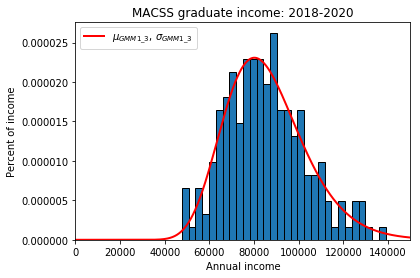

In [22]:
plt.hist(data, num_bins, density=True, edgecolor='k')
plt.title('MACSS graduate income: 2018-2020')
plt.xlabel(r'Annual income')
plt.ylabel('Percent of income')

sample = np.linspace(0, 150000, 200000)
plt.plot(sample, trunc_log_norm(sample, mu_GMM1_3, sigma_GMM1_3, 0.0, 150000.0),linewidth=2,
         color='r', label='$\mu_{GMM1\_3}$, $\sigma_{GMM1\_3}$')
plt.legend(loc='upper left')
plt.xlim([0, 150000]);

part (e)

In [33]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod
    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts <= 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts > 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [34]:
Err_mat3 = get_Err_mat3(data, mu_GMM1_3, sigma_GMM1_3, 0.0, 150000, False)
VCV2_3 = (1 / data.shape[0]) * (Err_mat3 @ Err_mat3.T)
print(VCV2_3)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3)
print(W_hat2_3)

[[ 2.33333068 -0.9999997  -0.99999962]
 [-0.9999997   1.00000053 -1.00000046]
 [-0.99999962 -1.00000046  4.00000154]]
[[ 0.25761782 -0.14958464 -0.01246545]
 [-0.14958464  0.11911371 -0.07340713]
 [-0.01246545 -0.07340713  0.20221599]]


In [35]:
params_init = np.array([mu_GMM1_3, sigma_GMM1_3])
gmm_args = (data, 0.0, 150000, W_hat2_3)
results2_3 = opt.minimize(criterion3, params_init, args=(gmm_args),
                          method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

results2_3

mu_GMM2_3= 11.336705110701544  sig_GMM2_3= 0.2115135758351846


      fun: array([[1.39043923e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.35784638e-06,  1.79932935e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 0
   status: 0
  success: True
        x: array([11.33670511,  0.21151358])

In [38]:
mu_GMM2_3, sigma_GMM2_3 = results2_3.x
func_value2_3 = results2_3.fun
bpct_1_model2_3, bpct_2_model2_3, bpct_3_model2_3 = model_moments3(mu_GMM2_3, sigma_GMM2_3, 0.0, 150000.0)
bpct_1_dat2_3, bpct_2_dat2_3, bpct_3_dat2_3 = data_moments3(data)
err2_3 = err_vec3(data, mu_GMM2_3, sigma_GMM2_3, 0.0, 150000, simple=True)
print(f'The value of the GMM criterion function: {func_value2_3}\n')
print(f'GMM estimated mu: {mu_GMM2_3}, GMM estimated simga: {sigma_GMM2_3}\n')
print('Percent(<75000) in data: {}, Percent(75000-100000) in data: {}, Percent(>100000) in data: {}'
      .format(bpct_1_dat2_3, bpct_2_dat2_3, bpct_3_dat2_3))
print('Percent(<75000) in model: {}, Percent(75000-100000) in model: {}, Percent(>100000) in model: {}\n'
      .format(bpct_1_model2_3, bpct_2_model2_3, bpct_3_model2_3))
print(f'The difference between data and model moments is \n {err2_3}.')

The value of the GMM criterion function: [[1.39043923e-13]]

GMM estimated mu: 11.336705110701544, GMM estimated simga: 0.2115135758351846

Percent(<75000) in data: 0.3, Percent(75000-100000) in data: 0.5, Percent(>100000) in data: 0.2
Percent(<75000) in model: 0.3000001704406224, Percent(75000-100000) in model: 0.4999998681822837, Percent(>100000) in model: 0.19999996137709433

The difference between data and model moments is 
 [[ 1.70440622e-07]
 [-1.31817716e-07]
 [-3.86229057e-08]].


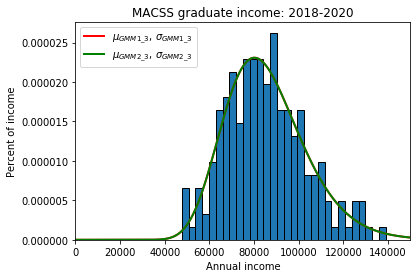

In [42]:
plt.hist(data, num_bins, density=True, edgecolor='k')
plt.title('MACSS graduate income: 2018-2020')
plt.xlabel(r'Annual income')
plt.ylabel('Percent of income')

sample = np.linspace(0, 150000, 200000)
plt.plot(sample, trunc_log_norm(sample, mu_GMM1_3, sigma_GMM1_3, 0.0, 150000.0),linewidth=2,
         color='r', label='$\mu_{GMM1\_3}$, $\sigma_{GMM1\_3}$')
plt.plot(sample, trunc_log_norm(sample, mu_GMM2_3, sigma_GMM2_3, 0.0, 150000.0),linewidth=2,
         color='g', label='$\mu_{GMM2\_3}$, $\sigma_{GMM2\_3}$')
plt.legend(loc='upper left')
plt.xlim([0, 150000]);

part (f)

In [45]:
import pandas as pd

In [46]:
mu = [mu_GMM1, mu_GMM2, mu_GMM1_3, mu_GMM2_3]
sigma = [sigma_GMM1, sigma_GMM2, sigma_GMM1_3, sigma_GMM2_3]
func_values = [func_value1, func_value2, func_value1_3, func_value2_3]
pd.DataFrame({"mu":mu,"sigma":sigma,"Value of GMM func":func_values}
            ,index=['2 moments & Identity Matrix','2 moments & Weighted Matrix',
                   '3 moments & Identity Matrix','3 moments & Weighted Matrix']) \
             .astype(float)

,mu,sigma,Value of GMM func
2 moments & Identity Matrix,11.333600,0.213255,6.399271e-16
2 moments & Weighted Matrix,11.333600,0.213255,2.643107e-15
3 moments & Identity Matrix,11.336705,0.211514,4.295747e-13
3 moments & Weighted Matrix,11.336705,0.211514,1.390439e-13


From the table above, we can know that although the estimated values of mu and sigma are almost identical acorss different methods, the first method has the least value of GMM function. So we can say that the model using two moments with identity matrix fits the data best.

## Problem 2

part (a)

In [97]:
import pandas as pd

In [100]:
df = pd.read_csv('data\sick.txt')
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [101]:
def data_moments_lr(df):
    return df['sick']

def model_moments_lr(age, children, avgtemp_winter, beta_0, beta_1, beta_2, beta_3):
    return beta_0 + beta_1 * age + beta_2 * children + beta_3 * avgtemp_winter

def err_vec_lr(df, age, children, avgtemp_winter, beta_0, beta_1, beta_2, beta_3):
    return data_moments_lr(df) - model_moments_lr(age, children, avgtemp_winter, beta_0, beta_1, beta_2, beta_3)

def criterion_lr(params, *args):
    beta_0, beta_1, beta_2, beta_3 = params
    df, age, children, avgtemp_winter, W = args
    err = err_vec_lr(df, age, children, avgtemp_winter, beta_0, beta_1, beta_2, beta_3)
    return err.T @ W @ err

In [106]:
age = df['age']
children = df['children']
avgtemp_winter = df['avgtemp_winter']
beta_0, beta_1, beta_2, beta_3 = 1, 0, 0, 0
params_init_lr = np.array([beta_0, beta_1, beta_2, beta_3])
W_hat_lr = np.eye(df.shape[0])
args_lr = (df, age, children, avgtemp_winter, W_hat_lr)
results_lr = opt.minimize(criterion_lr, params_init_lr, args=(args_lr), tol=1e-14, method='L-BFGS-B')
results_lr

      fun: 0.0018212898060782808
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.63237479e-07, -1.97918938e-06, -5.83402684e-06, -5.58679839e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 11
   status: 0
  success: True
        x: array([ 0.25164486,  0.01293347,  0.40050098, -0.00999171])

In [107]:
b0, b1, b2, b3 = results_lr.x
func_value_lr = results_lr.fun
print(f'Estimation for beta_0: {b0}')
print(f'Estimation for beta_1: {b1}')
print(f'Estimation for beta_2: {b2}')
print(f'Estimation for beta_3: {b3}')
print(f'The value of the GMM criterion function: {func_value_lr}')

Estimation for beta_0: 0.2516448636612042
Estimation for beta_1: 0.012933470965564249
Estimation for beta_2: 0.40050098470289774
Estimation for beta_3: -0.009991709711286762
The value of the GMM criterion function: 0.0018212898060782808
